In [1]:
import gmsh
import sys

gmsh.initialize()

# ----------------------- CREATE SHAPE --------------------------
gmsh.model.add("Polygon")

# Set bound vertices of Polygon

p1 = gmsh.model.geo.addPoint(-1.5, -1., 0)
p2 = gmsh.model.geo.addPoint( 0., -2.5, 0)
p3 = gmsh.model.geo.addPoint( 1.5, -1., 0)
p4 = gmsh.model.geo.addPoint( 1.5,  1., 0)
p5 = gmsh.model.geo.addPoint( 0.,  2.5, 0)
p6 = gmsh.model.geo.addPoint(-1.5,  1., 0)

# Set boundary lines

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addLine(p5, p6)
l6 = gmsh.model.geo.addLine(p6, p1)

# Make lines a surface
cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6])
pl = gmsh.model.geo.addPlaneSurface([cl])

gmsh.model.geo.synchronize()

# ----------------------- SETTINGS -----------------------------
gmsh.option.setNumber("Mesh.RecombineAll", 1)

# To generate quadrangles instead of triangles, we can simply add
gmsh.model.mesh.setRecombine(2, pl)

# 2D-quads Algorithm^ Frontal-Delaunay for quads"
# J.-F. Remacle, F. Henrotte, T. Carrier-Baudouin, E. Bechet,
# E. Marchandise, C. Geuzaine and T. Mouton. A frontal Delaunay quad mesh
# generator using the L^inf norm.

gmsh.option.setNumber("Mesh.Algorithm", 8)

# the full-quad recombination algorithm, which will automatically perform a coarser mesh
# followed by recombination, smoothing and subdivision.

gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2) # or 3

# ----------------------- GENERATE ------------------------------

gmsh.model.mesh.generate(2)
gmsh.model.mesh.recombine()
gmsh.model.mesh.refine()

# ----------------------- OPEN GUI ------------------------------
# Launch the GUI to see the results:
# gmsh.fltk.run()

# ----------------------- TAKE COORDINATES ----------------------

types_ents, tags_ents, node_tags_ents = gmsh.model.mesh.get_elements()
node_tags, node_coords, _ = gmsh.model.mesh.getNodes(-1, -1, True)

# ----------------------- WRITE RESULT --------------------------

gmsh.write("out.msh")
gmsh.finalize()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

pair_nodes_in_quad = lambda x: [[x[i], x[(i+1)%4]] for i in range(4)]

node_coords = node_coords.reshape(-1, 3)
node_tag_to_coord = dict(zip(node_tags, node_coords))
node_tag_to_id = dict(zip(node_tags, range(len(node_coords))))
print("Vertices:", node_coords.shape)

node_tags_per_line = node_tags_ents[0].reshape(-1, 2)
node_tags_per_quad = node_tags_ents[1].reshape(-1,4)

line_coord = np.array([[node_tag_to_coord[fr], node_tag_to_coord[to]]
                       for (fr, to) in node_tags_per_line])
line_coord2d = line_coord[:,:,:2] # 2d
print("Edges:", line_coord.shape)

quad_coord = np.array([[node_tag_to_coord[fr], node_tag_to_coord[to]]
                       for fournodes in node_tags_per_quad for (fr, to) in pair_nodes_in_quad(fournodes)])
quad_node_indices = np.array([[node_tag_to_id[tag] for tag in fournodes] for fournodes in node_tags_per_quad])
quad_coord2d = quad_coord[:,:,:2] # 2d
print("Quads:", quad_coord.shape)

Vertices: (245, 3)
Edges: (48, 2, 3)
Quads: (640, 2, 3)


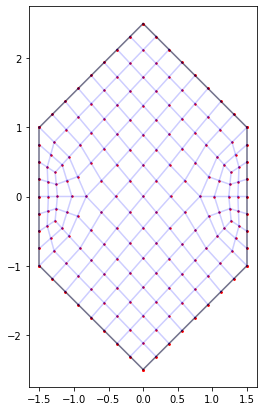

In [3]:
# simple 2D plot

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(line_coord2d[:,:,0].T, line_coord2d[:,:,1].T, c='k', alpha=0.5)
ax.plot(quad_coord2d[:,:,0].T, quad_coord2d[:,:,1].T, c='b', alpha=0.1)
ax.scatter(node_coords[:,0], node_coords[:,1], s=2, c='r')
ax.set_aspect(aspect=1)
plt.show()

In [4]:
import k3d
import meshio
import pymesh

# K3D plots only triangular meshes, thus we need to create array with 
# "triangular faces" - quad_edges (0-1-2-3 => 010 + 121 + 232 + 303)

faces_quad_for_k3d = np.array([[fournodes[i], fournodes[(i+1)%4], fournodes[i]] 
                               for fournodes in quad_node_indices for i in range(4)])

In [5]:
plot = k3d.plot()
plot += k3d.mesh(node_coords.astype(np.float32), faces_quad_for_k3d.astype(np.uint32), wireframe=True, color=2)
plot.display()

Output()

In [6]:
plot.camera = [0.3, -1.2, 4,
              0, 0, 0,
              -0.5, 0.8, 0.3]

In [7]:

# or we can triangulate the mesh for visualization only

mesh = pymesh.meshio.form_mesh(node_coords, quad_node_indices)
mesh = pymesh.quad_to_tri(mesh)

In [ ]:
plot = k3d.plot()
plot += k3d.mesh(mesh.vertices.astype(np.float32), mesh.faces.astype(np.uint32), wireframe=True, color=2)
plot.display()

In [ ]:
plot.camera = [0.3, -1.2, 4,
              0, 0, 0,
              -0.5, 0.8, 0.3]